In [279]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg 
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import os
import pandas as pd
from copy import deepcopy
from numpy.linalg import norm

In [280]:
random.seed(2022)
np.random.seed(2022)

In [281]:
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())

In [282]:
census_tracts['features'][0]['properties']

{'MOVEMENT_ID': '1', 'TRACT': '480302', 'DISPLAY_NAME': 'Census Tract 480302'}

In [256]:
np.array(census_tracts['features'][0]['geometry']['coordinates'][0]).mean(axis=0)  # [longitude, latitude]

array([-118.12053321,   34.10309557])

In [257]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [258]:
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [259]:
# Creating undirected graph with just node and node properties

g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())
g.vs['coordinates'] = list(coordinates.values())

In [260]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv') as f:
    f.readline()  # skip the first line since it's the headers.
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])
        
        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)

In [261]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [262]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [263]:
print(len(g.vs), len(g.es))

2649 1003858


In [264]:
copy_g = deepcopy(g)

In [265]:
uber_data  = pd.read_csv('./los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')

df = uber_data[uber_data['month']==12][['sourceid','dstid','mean_travel_time']]
data = df.values

In [278]:
arr = data
for i in range(0,len(arr)):
    if(arr[i][0]>arr[i][1]):
        t = arr[i][0]
        arr[i][0] = arr[i][1]
        arr[i][1] = t
newdf = pd.DataFrame(arr)
arr1 = newdf.groupby([0,1]).mean().reset_index()
arr1 = arr1.rename(columns={0: "source", 1: "sink", 2: "weight"})

g = nx.from_pandas_edgelist(arr1, 'source','sink', ['weight'])
gcc = g.subgraph(max(nx.connected_components(g), key=len))
mst = nx.minimum_spanning_tree(gcc)
mg = nx.MultiGraph()

In [ ]:
# mst_cost = sum(mst.edges['weight'])
for i in mst.edges:
    w = mst.edges[i[0],i[1]]['weight']
    mg.add_edge(i[0],i[1],weight=w)
    mg.add_edge(i[0],i[1],weight=w)


vertices, count = [], 0
for i in mg.nodes:
    vertices.append(i)
    count += 1
    if count>60: 
        break

In [ ]:
costs, current_paths = [], []
for vertex in vertices:
    tour = [u for u,v in nx.eulerian_circuit(mg,source=vertex)]
    path , visited_nodes = [], set()
    for i in tour:
        if i not in visited_nodes: 
            path.append(i) 
            visited_nodes.add(i) 
    path.append(path[0])
    current_paths.append(path)
    tsp_cost = 0
    for i in range(len(path)-1):
        s,t = path[i], path[i+1]
        w = 0
        if mst.has_edge(s,t): 
            w = mst.edges[s,t]['weight']
        else: 
            w = nx.dijkstra_path_length(gcc,s,t)
        tsp_cost += w
    costs.append(tsp_cost)

min_tsp_cost = min(costs)
trajectory = current_paths[np.argmin(costs)]

In [20]:
print('TSP cost:',round(min_tsp_cost))

TSP cost: 421489


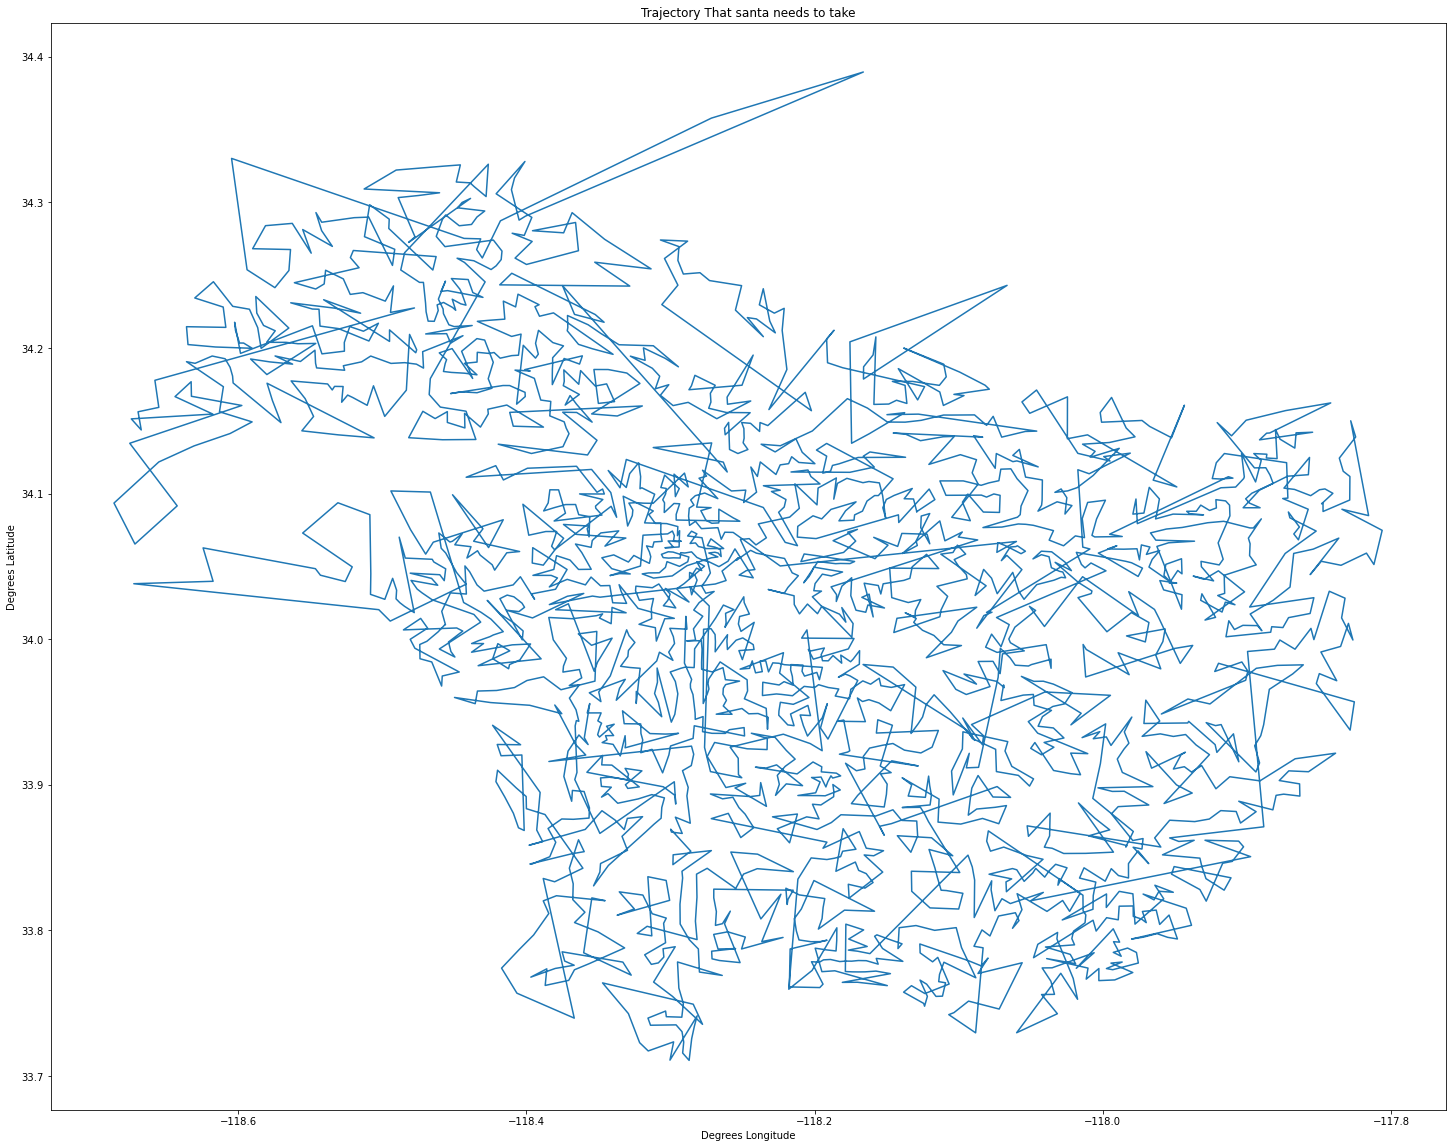

In [21]:
latitude = []
longitude = []

for i in trajectory:
    latitude.append(coordinates[int(i)][1])
    longitude.append(coordinates[int(i)][0])

plt.figure(figsize=(25,20))

plt.plot(longitude, latitude,'-')
plt.title('Trajectory That santa needs to take')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
# plt.savefig('Q13.png',dpi=500,bbox_inches='tight')
plt.show()

In [283]:
# Returns distance between two coordinates (lat, long) in km
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [26]:
total_distance = 0

for i in range(len(latitude) - 1):
    curr_lat = latitude[i]
    next_lat = latitude[i+1]
    curr_long = longitude[i]
    next_long = longitude[i+1]
    total_distance = total_distance + haversine(curr_lat, curr_long, next_lat, next_long)

print("Total Distance that needs to be covered by Santa using 1-Approximate Tour cost: ", total_distance)


Total Distance that needs to be covered by Santa using 1-Approximate Tour cost:  3963.955449046096


In [29]:
# Assuming the time to cover all the place is between 12 - 6 am on  Christmas, and on average there are 20 gifts
# that needs to be delivered for each coordinate. Assuming Santa takes 5 sec for each house to climb down the chimney
# and deliver gifts.

time_per_gift = 5 / 3600 #Hour
total_gift_delivery_time = len(latitude) * time_per_gift
speed = total_distance / (6 - total_gift_delivery_time)

In [32]:
print("Speed of travel for Santa to travel TSP path", speed, " Km/ hr")

Speed of travel for Santa to travel TSP path 1709.010732522868  Km/ hr


### Comparison of Different algorithms to solve TSP problem

#### Using Brute Force

In [284]:
from itertools import permutations
from math import hypot

def brute(cities):
    min_length = calc_length(cities, range(len(cities)))
    min_path = range(len(cities))

    for path in permutations(range(len(cities))):
        length = calc_length(cities, path)
        if length < min_length:
            min_length = length
            min_path = path

    return min_path, min_length


def dist_squared(c1, c2):
    t1 = c2[0] - c1[0]
    t2 = c2[1] - c1[1]

    return t1 ** 2 + t2 ** 2


def calc_length(cities, path):
    length = 0
    for i in range(len(path)):
        length += dist_squared(cities[path[i - 1]], cities[path[i]])

    return length


In [285]:
from time import time
f = open('tsp0734.txt', 'r').read().splitlines()
numCities = f.pop(0)
cities = np.array([tuple(map(float, coord.split())) for coord in f])

In [286]:
fullGraph = np.zeros((len(cities), len(cities)))

for i in range(len(cities)):
    for j in range(len(cities)):
        if(i >= j):
            continue
        P = cities[i]
        Q = cities[j]
        fullGraph[i, j] = np.square(P[0] - Q[0]) + np.square(P[1] - Q[1])
        fullGraph[j, i] = fullGraph[i, j]

In [192]:
bruteTimes = []
bruteCosts = []
for i in range(2, 11):
    start = time()
    (path, length) = brute(cities[0:i, :])
    print(path)

    tottime = time() - start
    print('Found path of length %s in %s seconds' % (round(length, 2),
            round(tottime, 2)))
    bruteTimes.append(tottime)
    bruteCosts.append(length)

range(0, 2)
Found path of length 571111.05 in 0.0 seconds
range(0, 3)
Found path of length 536111.04 in 0.0 seconds
(0, 1, 3, 2)
Found path of length 905555.47 in 0.0 seconds
(0, 1, 3, 4, 2)
Found path of length 778888.81 in 0.0 seconds
(0, 2, 1, 3, 4, 5)
Found path of length 747222.14 in 0.01 seconds
(0, 2, 1, 4, 3, 6, 5)
Found path of length 704999.89 in 0.05 seconds
(0, 2, 1, 4, 3, 7, 6, 5)
Found path of length 717222.1 in 0.27 seconds
(0, 2, 1, 4, 3, 8, 7, 6, 5)
Found path of length 1010555.4 in 2.58 seconds
(0, 2, 1, 4, 3, 7, 8, 9, 6, 5)
Found path of length 967777.64 in 28.48 seconds


Text(0.5, 1.0, 'Time to compute TSP using Brute force')

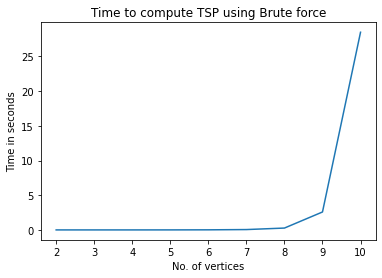

In [193]:
plt.plot(np.arange(2, 11), bruteTimes)
plt.xlabel("No. of vertices")
plt.ylabel("Time in seconds")
plt.title("Time to compute TSP using Brute force")

#### Using Dynamic Programming

In [154]:
def getGraph(v):
    vertices = v
    np.random.seed(2022)
    weighted_graph = np.random.randint(1, 10, [vertices, vertices])

    for i in range(vertices):
        for j in np.arange(i, vertices):
            if(i == j):
                weighted_graph[i, j] = 0
            weighted_graph[i, j] = weighted_graph[j, i]
    return weighted_graph

In [155]:
def compute(weighted_graph):
    for x in range(1, n):
        g[x + 1, ()] = weighted_graph[x][0]

    get_minimum(weighted_graph, 1, tuple(np.arange(2, n+1)))

    print('\n Solution to TSP: {1, ', end='')
    solution = p.pop()
    print(solution[1][0], end=', ')
    for x in range(n - 2):
        for new_solution in p:
            if tuple(solution[1]) == new_solution[0]:
                solution = new_solution
                print(solution[1][0], end=', ')
                break
    print('1}')
    return


def get_minimum(weighted_graph, k, a):
    if (k, a) in g:
        # Already calculated Set g[%d, (%s)]=%d' % (k, str(a), g[k, a]))
        return g[k, a]

    values = []
    all_min = []
    for j in a:
        set_a = deepcopy(list(a))
        set_a.remove(j)
        all_min.append([j, tuple(set_a)])
        result = get_minimum(weighted_graph, j, tuple(set_a))
        values.append(weighted_graph[k-1][j-1] + result)

    # get minimun value from set as optimal solution for
    g[k, a] = min(values)
    p.append(((k, a), all_min[values.index(g[k, a])]))

    return g[k, a]

In [156]:
import time
DPtimes = []

for i in range(5, 17):
    start = time.time()
    n = i
    gp = getGraph(i)
    all_sets = []
    g = {}
    p = []
    compute(gp)
    end = time.time()
    DPtimes.append(end - start)


 Solution to TSP: {1, 3, 4, 2, 5, 1}

 Solution to TSP: {1, 2, 3, 4, 6, 5, 1}

 Solution to TSP: {1, 3, 5, 4, 6, 2, 7, 1}

 Solution to TSP: {1, 2, 3, 6, 4, 7, 8, 5, 1}

 Solution to TSP: {1, 5, 4, 6, 3, 2, 9, 8, 7, 1}

 Solution to TSP: {1, 3, 7, 10, 5, 6, 2, 9, 4, 8, 1}

 Solution to TSP: {1, 4, 5, 6, 10, 11, 2, 9, 7, 3, 8, 1}

 Solution to TSP: {1, 4, 10, 5, 9, 6, 3, 12, 2, 7, 8, 11, 1}

 Solution to TSP: {1, 2, 11, 5, 3, 7, 6, 4, 10, 13, 12, 8, 9, 1}

 Solution to TSP: {1, 10, 9, 8, 3, 7, 14, 2, 4, 6, 11, 13, 5, 12, 1}

 Solution to TSP: {1, 9, 7, 6, 5, 3, 4, 13, 2, 14, 10, 12, 8, 15, 11, 1}

 Solution to TSP: {1, 6, 11, 4, 10, 14, 13, 2, 3, 12, 8, 15, 5, 7, 9, 16, 1}


Text(0.5, 1.0, 'Time to compute TSP using Dynamic Programming')

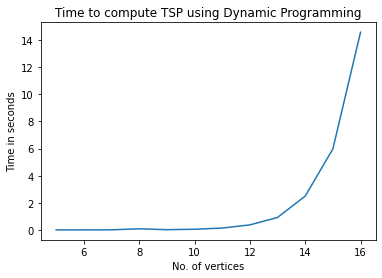

In [185]:
plt.plot(np.arange(5, 17), DPtimes)
plt.xlabel("No. of vertices")
plt.ylabel("Time in seconds")
plt.title("Time to compute TSP using Dynamic Programming")

#### Using Greedy Algorithm

In [213]:
import numpy as np
def greedy(cities):
    best_order = []
    best_length = float('inf')

    for (i_start, start) in enumerate(cities):
        order = [i_start]
        length = 0

        (i_next, next, dist) = get_closest(start, cities, order)
        length += dist
        order.append(i_next)

        while len(order) < cities.shape[0]:
            (i_next, next, dist) = get_closest(next, cities, order)
            length += dist
            order.append(i_next)

        if length < best_length:
            best_length = length
            best_order = order

    return (best_order, best_length)


def get_closest(city, cities, visited):
    best_distance = float('inf')

    for (i, c) in enumerate(cities):

        if i not in visited:
            distance = dist_squared(city, c)

            if distance < best_distance:
                closest_city = c
                i_closest_city = i
                best_distance = distance

    return (i_closest_city, closest_city, best_distance)


def dist_squared(c1, c2):
    t1 = c2[0] - c1[0]
    t2 = c2[1] - c1[1]

    return t1 ** 2 + t2 ** 2


In [214]:
greedyTimes = []
greedyCost = []
for i in range(2, 200):
    if(i % 10 == 0):
        print("Completed: ", i)
    start = time()
    (path, length) = greedy(cities[0:i, :])

    tottime = time() - start
    greedyTimes.append(tottime)
    greedyCost.append(length)

Completed:  10
Completed:  20
Completed:  30
Completed:  40
Completed:  50
Completed:  60
Completed:  70
Completed:  80
Completed:  90
Completed:  100
Completed:  110
Completed:  120
Completed:  130
Completed:  140
Completed:  150
Completed:  160
Completed:  170
Completed:  180
Completed:  190


Text(0.5, 1.0, 'Time to compute TSP using Greedy Method')

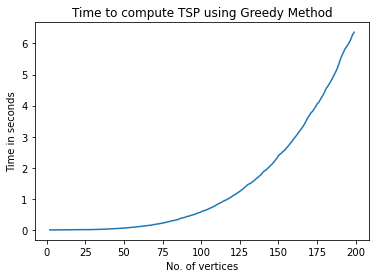

In [215]:
plt.plot(np.arange(2, 200), greedyTimes)
plt.xlabel("No. of vertices")
plt.ylabel("Time in seconds")
plt.title("Time to compute TSP using Greedy Method")

#### Using 2-opt swap

In [216]:
import numpy as np
from random import shuffle, randrange
from time import time

N_ITER = 10

def optswap(cities):
    best_order = []
    best_length = float('inf')

    for i in range(N_ITER):
        order = list(range(cities.shape[0]))
        shuffle(order)
        length = calc_length(cities, order)
        start = time()

        changed = True
        while changed:

            changed = False

            for a in range(-1, cities.shape[0]):

                for b in range(a + 1, cities.shape[0]):

                    new_order = order[:a] + order[a:b][::-1] + order[b:]
                    new_length = calc_length(cities, new_order)

                    if new_length < length:
                        length = new_length
                        order = new_order
                        changed = True

        if length < best_length:
            best_length = length
            best_order = order

    return (best_order, best_length)


def calc_length(cities, path):
    length = 0
    for i in range(len(path)):
        length += dist_squared(cities[path[i - 1]], cities[path[i]])

    return length


def dist_squared(c1, c2):
    t1 = c2[0] - c1[0]
    t2 = c2[1] - c1[1]

    return t1 ** 2 + t2 ** 2


def calc_length_C(cities, path):

    seq = [1,2,3,4,5,6,10] 
    t = 5
    cities = list(cities)

    code = \
        """
            float length = 0;
            for(int i=0; i < path.length(); i++){
            float c1x = cities[ (int) path[i-1] ][0];
            float c1y = cities[ (int) path[i-1] ][1];
            float c2x = cities[ (int) path[i] ][0];
            float c2y = cities[ (int) path[i] ][1];
            length += (c2x - c1x)*(c2x - c1x) - (c2y - c1y)*(c2y - c1y);
            }
            return_val = length;
        """
    
    length = 0
    for i in range(0, len(path)):
        c1x = cities[int(path[i-1])][0]
        c1y = cities[int(path[i-1])][1]
        c2x = cities[int(path[i])][0]
        c2y = cities[int(path[i])][0]
        length+= (c2x - c1x)*(c2x - c1x) - (c2y - c1y)*(c2y - c1y)
    
    return length


In [218]:
optTimes = []
optCost = []
for i in range(2, 70):
    if(i % 10 == 0):
        print("Completed: ", i)
    start = time()
    (path, length) = optswap(cities[0:i, :])

    tottime = time() - start
    optTimes.append(tottime)
    optCost.append(length)

Completed:  10
Completed:  20
Completed:  30
Completed:  40
Completed:  50
Completed:  60


Text(0.5, 1.0, 'Time to compute TSP using 2-opt Swap Method')

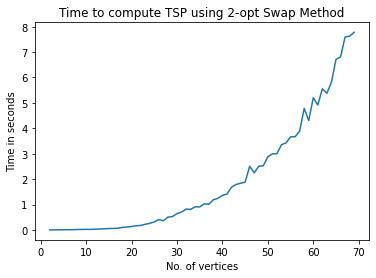

In [219]:
plt.plot(np.arange(2, 70), optTimes)
plt.xlabel("No. of vertices")
plt.ylabel("Time in seconds")
plt.title("Time to compute TSP using 2-opt Swap Method")

Text(0, 0.5, 'Time in seconds')

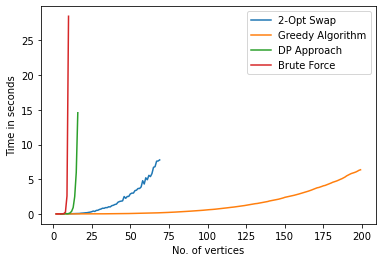

In [223]:
plt.plot(np.arange(2, 70), optTimes, label='2-Opt Swap')
plt.plot(np.arange(2, 200), greedyTimes, label = 'Greedy Algorithm')
plt.plot(np.arange(5, 17), DPtimes, label = 'DP Approach')
plt.plot(np.arange(2, 11), bruteTimes, label = 'Brute Force')
plt.legend()
plt.xlabel("No. of vertices")
plt.ylabel("Time in seconds")